In [17]:
from datetime import date
import pandas as pd
import matplotlib.pyplot as plt
import mysql.connector
pd.options.mode.chained_assignment = None

from IPython.display import display, Markdown, HTML


display(Markdown(f"### Letztes Update: {date.today()}"))

### Letztes Update: 2023-01-23

In [2]:
db = mysql.connector.connect(
    host="localhost",
    user="root",
    password="secret",
    port="3306",
    database="serlo",
    charset="latin1"
)

def cached(func):
    cache = dict()
    
    def return_func(arg):
        if (arg in cache):
            return cache[arg]
        else:
            result = func(arg)
            cache[arg] = result
            return result
    
    return return_func

def query(sql):
    c = db.cursor()
    c.execute(sql)
    
    return c.fetchall()

def querySingleton(sql):
    return [ x[0] for x in query(sql) ]

@cached
def getParent(termId):
    return querySingleton("""
        select parent_id from term_taxonomy where id = %s;
    """ % termId)[0]

def getTermName(termId):
    return querySingleton("""
        select term.name from term_taxonomy
        join term on term.id = term_taxonomy.term_id
        where term_taxonomy.id = %s;
    """ % termId)[0]

@cached
def getSubject(termId):
    if int(termId) in [79733, 81317, 20852, 87814, 87827, 85477, 87860, 75049, 76750, 87496, 75678, 91252, 91253]:
        return "Prüfungsbereich Mathematik"
    if int(termId) in [106082]:
        return getTermName(termId)
    
    parent = getParent(termId)
    grandparent = getParent(parent)
    
    if (parent == 106081):
        return getTermName(termId)
    
    return getSubject(parent) if grandparent != None else getTermName(termId)

@cached
def getSubjectFromUuid(uuid):
    taxonomyTerms = querySingleton(f"""
        select term_taxonomy_id from term_taxonomy_entity
        where term_taxonomy_entity.entity_id  = {uuid};
    """)
    
    if len(taxonomyTerms) > 0:
        return getSubject(taxonomyTerms[0])

    parents = querySingleton(f"""
        select parent_id from entity_link
        where entity_link.child_id  = {uuid};
    """)
    
    if len(parents) > 0:
        return getSubjectFromUuid(parents[0])
    
    return None

In [3]:
import json

json.dumps(querySingleton("""
select distinct(entity_link.parent_id ) from event_log join entity_link on entity_link.child_id = event_log.uuid_id where event_log.event_id = 4 and event_log.date > Date("2020-02-01");
"""));

In [4]:
def read_event_log():
    df = pd.read_sql("""
        select event_log.id, event_log.actor_id, event_log.date, user.username, event_parameter_uuid.uuid_id from event_log
        join user on user.id = event_log.actor_id
        join event_parameter on event_parameter.log_id = event_log.id
        join event_parameter_uuid on event_parameter_uuid.event_parameter_id = event_parameter.id
        where event_log.event_id = 5
        and year(event_log.date) > 2018
        and user.username != "Legacy"
    """, db)
    df.set_index("id", inplace=True)
    df.rename(columns={"uuid_id": "uuid"}, inplace=True)
    df["subject"] = df["uuid"].map(getSubjectFromUuid)
    return df

event_log = read_event_log()
event_log.head(100)

,actor_id,date,username,uuid,subject
id,,,,,
252170,95850,2019-01-02 10:35:03,Leo1,127338,Chemie
252172,95850,2019-01-02 10:58:42,Leo1,127338,Chemie
252180,95849,2019-01-02 11:46:55,hernlmax,63496,Chemie
252185,95849,2019-01-02 11:51:49,hernlmax,127428,Chemie
252187,95849,2019-01-02 11:52:47,hernlmax,127428,Chemie
...,...,...,...,...,...
252503,121732,2019-01-04 16:48:53,Jonathan,127576,Mathe
252505,121732,2019-01-04 16:49:01,Jonathan,127602,Mathe
252510,95854,2019-01-04 16:50:43,markus_janker,127600,Chemie


In [21]:
days = 90
edits = 10

def calc_avg_per_activity_status(edits=10, days=90):
    result_df = pd.DataFrame()

    lower_date = pd.Timestamp.today() - pd.Timedelta(days = days)
    upper_date = pd.Timestamp.today()

    df2 = event_log[lower_date < event_log['date']] 

    df3 = df2.groupby(by = ['actor_id', 'username'], as_index = False).count()
    #Delete all authors under baseline
    df4 = df3
    df4['isActive'] = df4['uuid'].apply(lambda x: 1 if x >= edits else 0)
    df4.drop(['date', 'subject'], axis=1, inplace=True)  

    df4 = df4.rename(columns={"uuid": "edits"})
    active_users_df = df4[df4['isActive'] == 1]

    return active_users_df["edits"]

# 1. Autor* Innen (min 1 Bearbeitung)

Autor*Innen: Edits = 1

Durchschnitt: 46.50666666666667

Median: 5.0

{'whiskers': [<matplotlib.lines.Line2D at 0x123675580>,
 'caps': [<matplotlib.lines.Line2D at 0x123675ca0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1236751f0>],
 'medians': [<matplotlib.lines.Line2D at 0x123680400>],
 'fliers': [<matplotlib.lines.Line2D at 0x123680790>],
 'means': []}

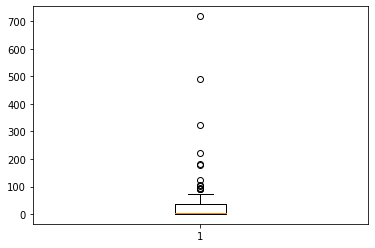

In [28]:
edits_author = calc_avg_per_activity_status(edits = 1)
display(Markdown(f"Autor*Innen: Edits = 1"))
display(Markdown(f"Durchschnitt: {edits_author.mean()}"))
display(Markdown(f"Median: {edits_author.median()}"))
plt.boxplot(edits_author)

# 2. Aktive Autor* Innen (min 10 Bearbeitung)

Autor*Innen: Edits = 10

Durchschnitt: 112.1

Median: 66.0

{'whiskers': [<matplotlib.lines.Line2D at 0x1236d88e0>,
 'caps': [<matplotlib.lines.Line2D at 0x1236e6040>,
 'boxes': [<matplotlib.lines.Line2D at 0x1236d8520>],
 'medians': [<matplotlib.lines.Line2D at 0x1236e6760>],
 'fliers': [<matplotlib.lines.Line2D at 0x1236e6af0>],
 'means': []}

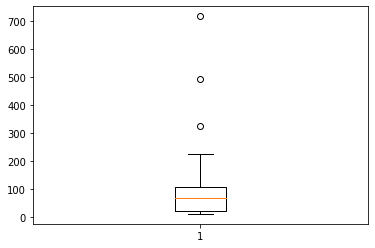

In [29]:
edits_author = calc_avg_per_activity_status(edits = 10)
display(Markdown(f"Autor*Innen: Edits = 10"))
display(Markdown(f"Durchschnitt: {edits_author.mean()}"))
display(Markdown(f"Median: {edits_author.median()}"))
plt.boxplot(edits_author)

# 2. Sehr aktive Autor* Innen (min 100 Bearbeitung)

Autor*Innen: Edits = 100

Durchschnitt: 272.44444444444446

Median: 181.0

{'whiskers': [<matplotlib.lines.Line2D at 0x12373be80>,
 'caps': [<matplotlib.lines.Line2D at 0x1237495e0>,
 'boxes': [<matplotlib.lines.Line2D at 0x12373baf0>],
 'medians': [<matplotlib.lines.Line2D at 0x123749d00>],
 'fliers': [<matplotlib.lines.Line2D at 0x1237540d0>],
 'means': []}

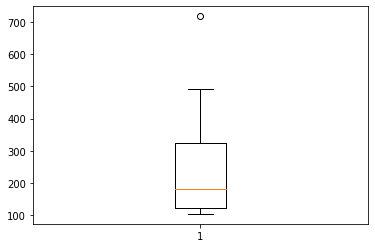

In [30]:
edits_author = calc_avg_per_activity_status(edits = 100)
display(Markdown(f"Autor*Innen: Edits = 100"))
display(Markdown(f"Durchschnitt: {edits_author.mean()}"))
display(Markdown(f"Median: {edits_author.median()}"))
plt.boxplot(edits_author)